<a href="https://colab.research.google.com/github/weiyangtimmy/stanford_cars_recognition/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cars Classification on the Stanford dataset (Google's EfficientNet)**
[[link](https://github.com/qubvel/efficientnet)] 

Mounting of the google drive is needed to run this code and installation of console_progressbar is required in the 2nd cell. 
  <br />
  <br />
The following files and directories are required before running this code:
  <br />
  <br />
My Drive/<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Grab Car AI/ <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[cars_test_annos_withlabels.mat](http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat)/<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;second_try/<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[cars_train.tgz](http://imagenet.stanford.edu/internal/car196/cars_train.tgz)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[cars_test.tgz](http://imagenet.stanford.edu/internal/car196/cars_test.tgz)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[car_devkit.tgz](https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz)<br />
<br />


---

The linked files can be downloaded 

In [1]:
#connect to Google Drive to run this code
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!python3.6 -m pip install console_progressbar

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
import numpy as np
import keras.layers as layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.models import Model
from keras import optimizers
from keras.utils import np_utils
from keras.models import model_from_json
import keras.backend as K
import time
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import scipy.io
import tarfile
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar
import pandas as pd
import matplotlib.pyplot as plt

# Pre-processing of .tgz files into subfolders by classes 

In [0]:
# This preprocessing portion of the code is provided by foamliu on his github repo
# https://github.com/foamliu/Car-Recognition/blob/master/pre-process.py


def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def save_train_data(fnames, labels, bboxes):
    src_folder ='/content/gdrive/My Drive/Grab Car AI/second_try/cars_train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '/content/gdrive/My Drive/Grab Car AI/second_try/data/train/'
        else:
            dst_folder = '/content/gdrive/My Drive/Grab Car AI/second_try/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def save_test_data(fnames, bboxes):
    src_folder = '//content//gdrive//My Drive//Grab Car AI//second_try//cars_test//'
    dst_folder = '/content/gdrive/My Drive/Grab Car AI/second_try/data/test/'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)


def process_train_data():
    print("Processing train data...")
    cars_annos = scipy.io.loadmat('/content/gdrive/My Drive/Grab Car AI/second_try/devkit/devkit/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)


def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('/content/gdrive/My Drive/Grab Car AI/second_try/devkit/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)


if __name__ == '__main__':
    # parameters
    img_width, img_height = 224, 224

    print('Extracting cars_train.tgz...')
    if not os.path.exists('/content/gdrive/My Drive/Grab Car AI/second_try/cars_train'):
        with tarfile.open('/content/gdrive/My Drive/Grab Car AI/second_try/cars_train.tgz', "r:gz") as tar:
            tar.extractall(path='/content/gdrive/My Drive/Grab Car AI/second_try/')
    print('Extracting cars_test.tgz...')
    if not os.path.exists('/content/gdrive/My Drive/Grab Car AI/second_try/cars_test'):
        with tarfile.open('/content/gdrive/My Drive/Grab Car AI/second_try/cars_test.tgz', "r:gz") as tar:
            tar.extractall(path='/content/gdrive/My Drive/Grab Car AI/second_try/')
    print('Extracting car_devkit.tgz...')
    if not os.path.exists('/content/gdrive/My Drive/Grab Car AI/second_try/devkit'):
        with tarfile.open('/content/gdrive/My Drive/Grab Car AI/second_try/car_devkit.tgz', "r:gz") as tar:
            tar.extractall(path='/content/gdrive/My Drive/Grab Car AI/second_try/')

    cars_meta = scipy.io.loadmat('/content/gdrive/My Drive/Grab Car AI/second_try/devkit/devkit/cars_meta')
    class_names = cars_meta['class_names']  # shape=(1, 196)
    class_names = np.transpose(class_names)
    print('class_names.shape: ' + str(class_names.shape))
    print('Sample class_name: [{}]'.format(class_names[8][0][0]))

    ensure_folder('/content/gdrive/My Drive/Grab Car AI/second_try/data/train')
    ensure_folder('/content/gdrive/My Drive/Grab Car AI/second_try/data/valid')
    ensure_folder('/content/gdrive/My Drive/Grab Car AI/second_try/data/test')

    process_train_data()
    process_test_data()

    # clean up
    #shutil.rmtree('/content/gdrive/My Drive/Grab Car AI/second_try/cars_train')
    #shutil.rmtree('/content/gdrive/My Drive/Grab Car AI/second_try/cars_test')
# shutil.rmtree('devkit')

Extracting cars_train.tgz...
Extracting cars_test.tgz...
Extracting car_devkit.tgz...
class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The numbe

Change batch_size and epochs for the training of efficienet model here

In [0]:
batch_size = 32

width = 224
height = 224
epochs = 20
NUM_TRAIN = 6515 
NUM_TEST = 1629
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#install google's efficientnet
!pip install git+https://github.com/qubvel/efficientnet
from efficientnet import EfficientNetB3
conv_base = EfficientNetB3(weights='imagenet', input_shape = input_shape, include_top=False)

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-0gubddeb
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-0gubddeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-1b27t24q/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


W0617 03:30:29.833793 140238606284672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 03:30:29.872684 140238606284672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 03:30:29.879093 140238606284672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/efficientnet/initializers.py:30: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0617 03:30:30.015630 140238606284672 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 03:30:30.016672 140238606284672 depre

43974656/43966704 [==============================] - 2s 0us/step


Usage of ImageDataGenerator from Keras to view the images by classes

In [5]:
train_dir = "/content/gdrive/My Drive/Grab Car AI/second_try/data/train"
validation_dir = "/content/gdrive/My Drive/Grab Car AI/second_try/data/valid"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [6]:
#another method of training
#install google's efficientnet
!pip install git+https://github.com/qubvel/efficientnet
from efficientnet import EfficientNetB3
model = EfficientNetB3(weights='imagenet', input_shape = input_shape, include_top=False)
model.trainable = False
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(units = 196, activation="softmax")(x)
model_f = Model(input = model.input, output = predictions)
model_f.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-vh8biva2
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-vh8biva2
  Stored in directory: /tmp/pip-ephem-wheel-cache-005oftpo/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


W0617 03:36:15.313932 140477069600640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 03:36:15.329666 140477069600640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 03:36:15.332805 140477069600640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/efficientnet/initializers.py:30: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0617 03:36:15.355055 140477069600640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0617 03:36:15.355932 140477069600640 depre

In [0]:
dropout_rate = 0.2
model = Sequential()
conv_base.trainable = False
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(196, activation="softmax", name="fc_out"))
model.compile(
    optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy']
)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.735329 to fit



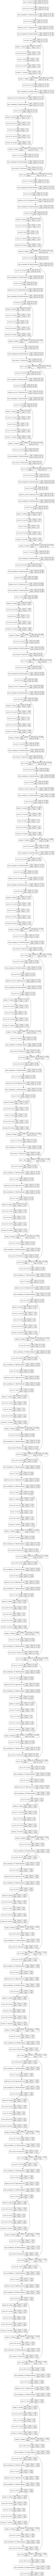

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(conv_base, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv_base.png') 

In [7]:
history = model_f.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

W0617 03:36:28.083037 140477069600640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


203/203 [==============================] - 447s 2s/step - loss: 1.9938 - acc: 0.7004 - val_loss: 5.1311 - val_acc: 0.0638
Epoch 2/20
203/203 [==============================] - 406s 2s/step - loss: 1.8524 - acc: 0.7027 - val_loss: 4.7822 - val_acc: 0.0675
Epoch 3/20
203/203 [==============================] - 405s 2s/step - loss: 1.7344 - acc: 0.7107 - val_loss: 4.2779 - val_acc: 0.1013
Epoch 4/20
203/203 [==============================] - 424s 2s/step - loss: 1.6191 - acc: 0.7223 - val_loss: 3.7746 - val_acc: 0.2037
Epoch 5/20
203/203 [==============================] - 159s 783ms/step - loss: 1.3337 - acc: 0.7574 - val_loss: 3.6885 - val_acc: 0.2280
Epoch 6/20
203/203 [==============================] - 158s 777ms/step - loss: 1.2941 - acc: 0.7574 - val_loss: 3.3903 - val_acc: 0.2988
Epoch 7/20
203/203 [==============================] - 158s 777ms/step - loss: 1.2688 - acc: 0.7563 - val_loss: 3.1346 - val_acc: 0.3113
Epoch 8/20
203/203 [==============================] - 158s 777ms/step -

In [0]:
# get evaluation result
cars_annos = scipy.io.loadmat('/content/gdrive/My Drive/Grab Car AI/second_try/devkit/devkit/cars_test_annos.mat')
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

fnames = []
bboxes = []

for annotation in annotations:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    fname = annotation[0][4][0]
    bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
    fnames.append(fname)

In [17]:
pb = ProgressBar(total=100, prefix='Predicting test data', suffix='', decimals=3, length=50, fill='=')
num_samples = 8041
start = time.time()
out = open('/content/gdrive/My Drive/Grab Car AI/second_try/20epochs_result.txt', 'a')
for i in range(num_samples):
    filename = os.path.join('/content/gdrive/My Drive/Grab Car AI/second_try/data/test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = model_f.predict(rgb_img)
    prob = np.max(preds)
    class_id = np.argmax(preds)
    out.write('{}\n'.format(str(class_id + 1)))
    pb.print_progress_bar((i + 1) * 100 / num_samples)

end = time.time()
seconds = end - start
print('avg fps: {}'.format(str(num_samples / seconds)))

out.close()
#K.clear_session()

Predicting test data |==================================================| 100.000% 
avg fps: 37.59933751298518


In [18]:
#evaluates current model
labels = sio.loadmat('/content/gdrive/My Drive/Grab Car AI/cars_test_annos_withlabels.mat')
x = []
for i in range(8041):
    x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])
    
df=pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),
                  index=x)
#df.to_csv('/content/gdrive/My Drive/Grab Car AI/second_try/test_labels.csv')
data = pd.read_csv('/content/gdrive/My Drive/Grab Car AI/second_try/20epochs_result.txt', sep="\n", header=None)
data.columns = ["data_create"]
df.columns=["0"]
rows = len(df.index)
count = 0
for i in range(rows):
  if df["0"][i] == data["data_create"][i]:
    count+=1
print(str("no. of correct images: " + str(count)))
percentage_eval = count/rows * 100
print(str("percentage eval:" + "%.2f" % percentage_eval + "%"))

no. of correct images: 68
percentage eval:0.85%


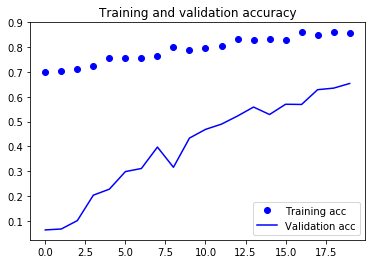

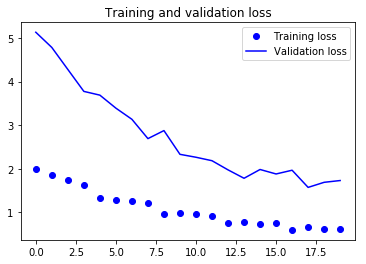

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The actual evaluation result was poor when i tried to use the pre-trained model as such with little training despite how it showed high accuracy. </br>
I decided to make parts of the efficientnetB3 trainable as well in an attempt to use the pre-trained weights better. </br>
The highlighted parts of the model was the weights i decided to change
![alt text](https://github.com/weiyangtimmy/stanford_cars_recognition/blob/master/part_of_efficientnet3.png?raw=true)

In [0]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'cov2d_208':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
model_f.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])

history = model_f.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
203/203 [==============================] - 88s 435ms/step - loss: 0.3656 - acc: 0.9070 - val_loss: 1.8055 - val_acc: 0.6488
Epoch 2/20
203/203 [==============================] - 75s 371ms/step - loss: 0.3338 - acc: 0.9147 - val_loss: 1.6186 - val_acc: 0.6600
Epoch 3/20
203/203 [==============================] - 76s 373ms/step - loss: 0.3215 - acc: 0.9121 - val_loss: 1.4682 - val_acc: 0.7100
Epoch 4/20
203/203 [==============================] - 75s 371ms/step - loss: 0.2961 - acc: 0.9233 - val_loss: 1.6167 - val_acc: 0.6613
Epoch 5/20
203/203 [==============================] - 76s 373ms/step - loss: 0.2475 - acc: 0.9334 - val_loss: 1.6521 - val_acc: 0.6839
Epoch 6/20
203/203 [==============================] - 76s 372ms/step - loss: 0.2470 - acc: 0.9332 - val_loss: 1.6476 - val_acc: 0.6925
Epoch 7/20
203/203 [==============================] - 75s 371ms/step - loss: 0.2190 - acc: 0.9413 - val_loss: 1.9673 - val_acc: 0.6550
Epoch 8/20
203/203 [==============================] - 7

In [28]:
# serialize model to JSON
model_json = model_f.to_json()
with open("/content/gdrive/My Drive/Grab Car AI/second_try/transfer_learning.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_f.save_weights("/content/gdrive/My Drive/Grab Car AI/second_try/transfer_learning.h5")
print("Saved model to disk")

Saved model to disk


**START here for additional training of previously trained models:**

In [0]:
# load json and create model
json_file = open('/content/gdrive/My Drive/Grab Car AI/second_try/transfer_learning.json', 'r')
#json_file = open('/content/gdrive/My Drive/Grab Car AI/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/gdrive/My Drive/Grab Car AI/second_try/transfer_learning.h5")
#loaded_model.load_weights("/content/gdrive/My Drive/Grab Car AI/model.h5")
print("Loaded model from disk")

W0617 02:09:54.916499 140036248307584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Loaded model from disk


In [0]:
cars_annos = scipy.io.loadmat('/content/gdrive/My Drive/Grab Car AI/second_try/devkit/devkit/cars_test_annos.mat')
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

fnames = []
bboxes = []

for annotation in annotations:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    fname = annotation[0][4][0]
    bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
    fnames.append(fname)


In [30]:
pb = ProgressBar(total=100, prefix='Predicting test data', suffix='', decimals=3, length=50, fill='=')
num_samples = 8041
start = time.time()
out = open('/content/gdrive/My Drive/Grab Car AI/second_try/40epochs_result.txt', 'a')
for i in range(num_samples):
    filename = os.path.join('/content/gdrive/My Drive/Grab Car AI/second_try/data/test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = model_f.predict(rgb_img)
    prob = np.max(preds)
    class_id = np.argmax(preds)
    out.write('{}\n'.format(str(class_id + 1)))
    pb.print_progress_bar((i + 1) * 100 / num_samples)

end = time.time()
seconds = end - start
print('avg fps: {}'.format(str(num_samples / seconds)))

out.close()
#K.clear_session()

Predicting test data |==================================================| 100.000% 
avg fps: 36.09952460765249


In [32]:
#evaluates current model
labels = sio.loadmat('/content/gdrive/My Drive/Grab Car AI/cars_test_annos_withlabels.mat')
x = []
for i in range(8041):
    x.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])
    
df=pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'],dtype=np.int)),
                  index=x)
#df.to_csv('/content/gdrive/My Drive/Grab Car AI/second_try/test_labels.csv')
data = pd.read_csv('/content/gdrive/My Drive/Grab Car AI/second_try/40epochs_result.txt', sep="\n", header=None)
data.columns = ["data_create"]
df.columns=["0"]
rows = len(df.index)
count = 0
for i in range(rows):
  if df["0"][i] == data["data_create"][i]:
    count+=1
print(str("no. of correct images: " + str(count)))
percentage_eval = count/rows * 100
print(str("percentage eval:" + "%.2f" % percentage_eval + "%"))

no. of correct images: 48
percentage eval:0.60%


# Conclusion:

The model clearly requires more training and this was my third attempt after joining the competition late with only 4 days left to go on top of my other commitments. Microsoft Azure free was slower than google colab so i ran most of files in google colab. I did not have time to attempt on AWS but would attempt to do so after the deadline and hope that it would be faster.